<a href="https://colab.research.google.com/github/AmbiTyga/Bio-VI-BERT/blob/main/Baselines-EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git -q
!pip install pytorch-lightning -q
!git clone https://github.com/FrancescoSaverioZuppichini/A-journey-into-Convolutional-Neural-Network-visualization-.git

     |████████████████████████████████| 849kB 10.7MB/s 
     |████████████████████████████████| 829kB 23.9MB/s 
     |████████████████████████████████| 184kB 38.2MB/s 
     |████████████████████████████████| 276kB 37.9MB/s 
     |████████████████████████████████| 112kB 38.2MB/s 
     |████████████████████████████████| 1.3MB 39.6MB/s 
     |████████████████████████████████| 296kB 37.1MB/s 
     |████████████████████████████████| 143kB 40.3MB/s 
Cloning into 'A-journey-into-Convolutional-Neural-Network-visualization-'...
remote: Enumerating objects: 238, done.
remote: Total 238 (delta 0), reused 0 (delta 0), pack-reused 238
Receiving objects: 100% (238/238), 106.41 MiB | 13.42 MiB/s, done.
Resolving deltas: 100% (70/70), done.


In [2]:
!wget https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Train.7z
!7z x /content/Train.7z

--2021-05-03 07:48:03--  https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Train.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13524763 (13M) [application/octet-stream]
Saving to: ‘Train.7z’

Train.7z            100%[===================>]  12.90M  --.-KB/s    in 0.1s    

2021-05-03 07:48:04 (86.5 MB/s) - ‘Train.7z’ saved [13524763/13524763]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 13524763 bytes (13 MiB)

Extracting archive: /content/Train.7z
--
Path = /content/Train.7z
Ty

In [3]:
!wget https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Val.7z
!7z x /content/Val.7z

--2021-05-03 07:48:06--  https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Val.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4593856 (4.4M) [application/octet-stream]
Saving to: ‘Val.7z’

Val.7z              100%[===================>]   4.38M  --.-KB/s    in 0.09s   

2021-05-03 07:48:06 (47.3 MB/s) - ‘Val.7z’ saved [4593856/4593856]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 4593856 bytes (4487 KiB)

Extracting archive: /content/Val.7z
--
Path = /content/Val.7z
Type = 7z
Phy

In [4]:
import timm
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, sampler
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.model_selection import train_test_split
from glob import glob
from PIL import Image
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from pytorch_lightning.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import cv2

## Labeling

In [ ]:
from glob import glob
images = [x for x in glob('./val/*/*') if 'val.csv' not in x]
for i in images:
  Image.open(i).convert('RGB').save(i)

In [5]:
train = pd.read_csv('/content/train/train.csv')
val = pd.read_csv('/content/val/val.csv')

In [6]:
train_transformer = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

val_transformer = transforms.Compose([
        transforms.Resize((224,224)),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

In [7]:
class SpeciesDataset(Dataset):
  def __init__(self,csv_file,transform,x):
    super().__init__()
    csv = csv_file[[f'{x}_label','img_path']]
    self.labels = csv[f'{x}_label'].values

    self.images = csv['img_path'].values
    self.transform = transform

    # self.LE = LabelEncoder()
    # self.labels = self.LE.fit_transform(labels)    

  def __len__(self):
    # return size of dataset
    return len(self.images)

  def __getitem__(self, index):
    img = Image.open(self.images[index])
    img = self.transform(img)

    label = self.labels[index]

    return {'images':img, 'labels':label}

In [12]:
class EB0(pl.LightningModule):
  def __init__(
      self,
      num_classes_classifier,
      train_weights,
      val_weights,
      train_dataset,
      val_dataset,
      sampling_rate):
    super().__init__()
    self.tr = sampling_rate[0]
    self.vr = sampling_rate[1]
    self.tw = train_weights
    self.vw = val_weights

    self.train_dataset = train_dataset
    self.val_dataset = val_dataset

    self.loss_fn = nn.CrossEntropyLoss()

    self.img_transformer = timm.models.efficientnet_b0(pretrained=True,num_classes = num_classes_classifier)
    
  def forward(self,img):  
    return self.img_transformer(img)

  def train_dataloader(self):
    return torch.utils.data.DataLoader(
        self.train_dataset,
        batch_size=48,
        sampler=torch.utils.data.WeightedRandomSampler(self.tw,num_samples=self.tr),
        num_workers = os.cpu_count()
        )

  def val_dataloader(self):
    return torch.utils.data.DataLoader(
        self.val_dataset,
        batch_size = 51,
        sampler = torch.utils.data.WeightedRandomSampler(self.vw,num_samples=self.vr),
        num_workers = os.cpu_count()
        )
    
  def training_step(self, batch ,batch_idx):
    images = batch["images"]
    labels = batch['labels']
    outputs = self(img=images)
    loss = self.loss_fn(outputs,labels)
    acc = (outputs.argmax(dim=1).view(labels.size()).data == labels.data).sum()/labels.size(0)
    
    # self.log("loss",loss,prog_bar=True)
    self.log("accuracy",acc,prog_bar=True)
    return {"loss": loss,'accuracy':acc}

  def validation_step(self, batch ,batch_idx):
    images = batch["images"]
    labels = batch['labels']
    outputs = self(img=images)
    loss = self.loss_fn(outputs,labels)
    acc = (outputs.argmax(dim=1).view(labels.size()).data == labels.data).sum()/labels.size(0)
    
    return {"val_loss": loss.item(),'val_accuracy':acc.item()}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.tensor(
            [output["val_loss"] 
            for output in outputs]
            ).mean()
    avg_acc = torch.tensor(
            [output["val_accuracy"] 
            for output in outputs]
            ).mean()
    
    self.log("val_loss",avg_loss,prog_bar=True)
    self.log("val_accuracy",avg_acc,prog_bar=True)

  def configure_optimizers(self):
    optimizer = [torch.optim.AdamW(
            self.parameters(), 
            lr=1e-4
        )]
    return optimizer

# Class

In [10]:

le = LabelEncoder()

train['class_label'] = le.fit_transform(train['class'])
val['class_label'] = le.transform(val['class'])

In [13]:

class_counts = train['class_label'].value_counts().to_dict()
train_weights = torch.tensor([1/class_counts[label] for label in train['class_label'].values])

train_dataset = SpeciesDataset(train,train_transformer,'class')

class_counts = val['class_label'].value_counts().to_dict()
val_weights = torch.tensor([1/class_counts[label] for label in val['class_label'].values])

val_dataset = SpeciesDataset(val,val_transformer,'class')

In [15]:
model = EB0(
    num_classes_classifier=7,
    train_weights=train_weights,
    val_weights=val_weights,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    sampling_rate = [3360,1155]
    )

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


In [16]:
early_stop_callback = EarlyStopping(
   monitor='val_accuracy',
   min_delta=0.00,
   patience=20,
   verbose=False,
   mode='max'
)

model_ckpt = ModelCheckpoint(
    monitor='val_accuracy',
    dirpath='./',
    filename='effNet-{val_loss:.2f}-{val_accuracy:.2f}',
    mode='max')

trainer = pl.Trainer(gpus=1,max_epochs=120,accumulate_grad_batches=4,num_sanity_val_steps=2,callbacks=[early_stop_callback,model_ckpt])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params
-----------------------------------------------------
0 | loss_fn         | CrossEntropyLoss | 0     
1 | img_transformer | EfficientNet     | 4.0 M 
-----------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.066    Total estimated model params size (MB)


1

### Accuracy

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

val_dataset = SpeciesDataset(val,val_transformer,'class')
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=51)

model = ResNet200d.load_from_checkpoint("../content/effNet-val_loss=1.64-val_accuracy=0.71.ckpt",num_classes_classifier=7,
    train_weights=None,
    val_weights=None,
    train_dataset=None,
    val_dataset=None,
    sampling_rate = [0,0]
    )
model.cuda()
model.eval()
preds = np.array([])
label = np.array([])
with torch.no_grad():
  for batch in val_loader:
    images = batch["images"].cuda()
    labels = batch['labels']
    label = np.append(label,labels)
    prediction = model(images)
    preds = np.append(preds,prediction.argmax(dim=1).view(labels.size()).cpu().numpy())


print(classification_report(label,preds,target_names=le.classes_))

               precision    recall  f1-score   support

 Aconoidasida       0.95      0.98      0.97       165
      Cestoda       0.60      0.36      0.45        50
  Chromadorea       0.65      0.79      0.71        95
  Conoidasida       0.69      0.89      0.78        80
      Enoplea       0.71      0.48      0.57        25
    Tubulinea       0.88      0.63      0.73        35
Zooflagellate       0.92      0.63      0.75        35

     accuracy                           0.79       485
    macro avg       0.77      0.68      0.71       485
 weighted avg       0.79      0.79      0.78       485



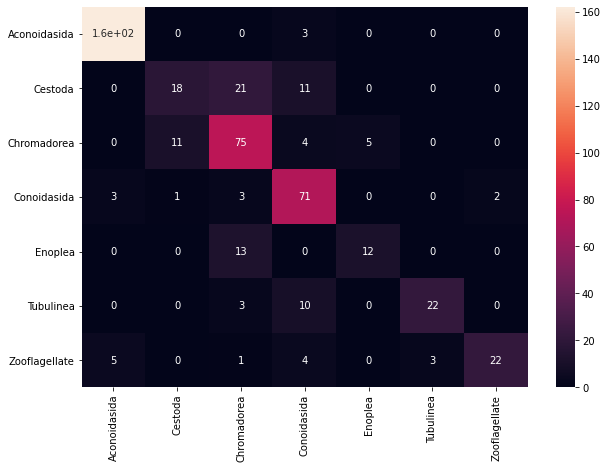

In [24]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
confusion = confusion_matrix(label,preds)
df_cm = pd.DataFrame(confusion, index = le.classes_,
                  columns = le.classes_)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

In [25]:
!unzip -q ../content/EffNet-B0.zip

### GradCam

In [30]:
%cd A-journey-into-Convolutional-Neural-Network-visualization-/

/content


In [27]:
from utils import *
from visualisation.core.utils import device 
from visualisation.core.utils import image_net_postprocessing
from torchvision.transforms import ToTensor, Resize, Compose, ToPILImage
from visualisation.core import *
from visualisation.core.utils import image_net_preprocessing

test_transform = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     image_net_preprocessing])

vis = GradCam(model, device)

In [53]:
def plot_get(img_path):
  img = test_transform(Image.open(img_path).convert('RGB')).unsqueeze(0).to(device)
  arr = tensor2img(vis(img, None,postprocessing=image_net_postprocessing)[0])
  arr = (arr*255).astype(np.uint8)
  img_path = img_path.split('/')
  save_path = '/'.join(img_path[:6]) + '/' + img_path[4] + '=' + img_path[6]
  Image.fromarray(arr).save(save_path)
  return Image.fromarray(arr)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


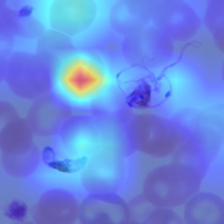

In [54]:
plot_get("/content/EffNet-B0/Class/Aconoidasida/Falciparium/Pf_gametocyte_thinF_0_232.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


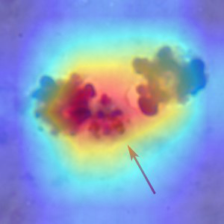

In [55]:
plot_get("/content/EffNet-B0/Class/Aconoidasida/Ovale/Po_gametocyte_thickB_0_285.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


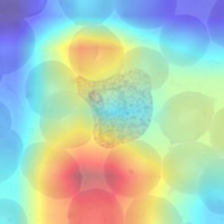

In [56]:
plot_get("/content/EffNet-B0/Class/Aconoidasida/Vivax/Pv_troph_thinC_0_312.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


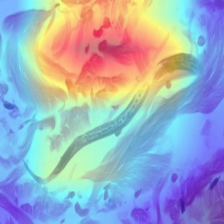

In [57]:
plot_get("/content/EffNet-B0/Class/Chromadorea/Stercoralis/S_stercoralis_intbiopsy_400x_BAM1_0_367.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


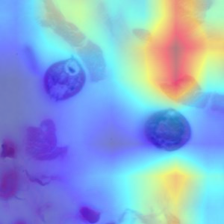

In [58]:
plot_get("/content/EffNet-B0/Class/Chromadorea/Stercoralis1K/S_stercoralis_intbiopsy_1000x_BAM1_0_366.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


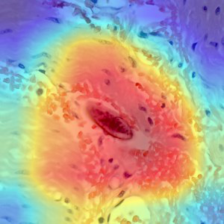

In [59]:
plot_get("/content/EffNet-B0/Class/Chromadorea/vermicularis/E_vermicularis_eggs_tissue2_0_157.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


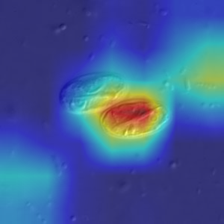

In [60]:
plot_get("/content/EffNet-B0/Class/Zooflagellate/Giardia_cyst_dic/Giardia_cyst_dic2_0_165.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


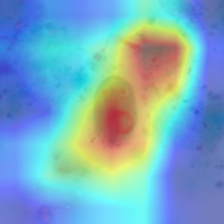

In [61]:
plot_get("/content/EffNet-B0/Class/Zooflagellate/Giardia_cyst_tric/Giardia_cyst_tric4_0_174.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


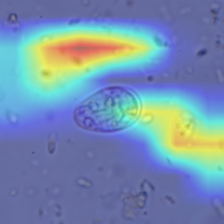

In [62]:
plot_get("/content/EffNet-B0/Class/Zooflagellate/Giardia_cyst_wtmt/Giardia_cyst_wtmt4_0_163.jpg")

In [64]:
!zip -rq EffNet-B0.zip EffNet-B0

# Phylum

In [65]:

le = LabelEncoder()

train['phylum_label'] = le.fit_transform(train['phylum'])
val['phylum_label'] = le.transform(val['phylum'])

In [66]:

class_counts = train['phylum_label'].value_counts().to_dict()
train_weights = torch.tensor([1/class_counts[label] for label in train['phylum_label'].values])

train_dataset = SpeciesDataset(train, train_transformer,'phylum')

class_counts = val['phylum_label'].value_counts().to_dict()
val_weights = torch.tensor([1/class_counts[label] for label in val['phylum_label'].values])

val_dataset = SpeciesDataset(val, val_transformer,'phylum')

In [ ]:
le.classes_

array(['Amoebozoa', 'Apicomplexa', 'Nematoda', 'Platyhelminthes',
       'Sarcomastigophora'], dtype=object)

In [67]:
model = EB0(
    num_classes_classifier=5,
    train_weights=train_weights,
    val_weights=val_weights,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    sampling_rate = [3550,1225]
    )

In [68]:
early_stop_callback = EarlyStopping(
   monitor='val_accuracy',
   min_delta=0.00,
   patience=20,
   verbose=False,
   mode='max'
)

model_ckpt = ModelCheckpoint(
    monitor='val_accuracy',
    dirpath='./',
    filename='EffNet-{val_loss:.2f}-{val_accuracy:.2f}',
    mode='max')

trainer = pl.Trainer(gpus=1,max_epochs=120,accumulate_grad_batches=4,num_sanity_val_steps=2,callbacks=[early_stop_callback,model_ckpt])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params
-----------------------------------------------------
0 | loss_fn         | CrossEntropyLoss | 0     
1 | img_transformer | EfficientNet     | 4.0 M 
-----------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.056    Total estimated model params size (MB)


1

### Accuracy

In [69]:
from sklearn.metrics import classification_report, confusion_matrix

val_dataset = SpeciesDataset(val, val_transformer,'phylum')
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=51)

model = ResNet200d.load_from_checkpoint("/content/EffNet-val_loss=1.46-val_accuracy=0.70.ckpt",
                                        num_classes_classifier=5,
                                        train_weights=None,
                                        val_weights=None,
                                        train_dataset=None,
                                        val_dataset=None,
                                        sampling_rate = [0,0]
                                        )
model.cuda()
model.eval()
preds = np.array([])
label = np.array([])
with torch.no_grad():
  for batch in val_loader:
    images = batch["images"].cuda()
    labels = batch['labels']
    label = np.append(label,labels)
    prediction = model(images)
    preds = np.append(preds,prediction.argmax(dim=1).view(labels.size()).cpu().numpy())


print(classification_report(label,preds,target_names=le.classes_))

                   precision    recall  f1-score   support

        Amoebozoa       0.58      0.51      0.55        35
      Apicomplexa       0.90      0.96      0.93       245
         Nematoda       0.78      0.84      0.81       120
  Platyhelminthes       0.56      0.38      0.45        50
Sarcomastigophora       0.79      0.66      0.72        35

         accuracy                           0.82       485
        macro avg       0.72      0.67      0.69       485
     weighted avg       0.80      0.82      0.81       485



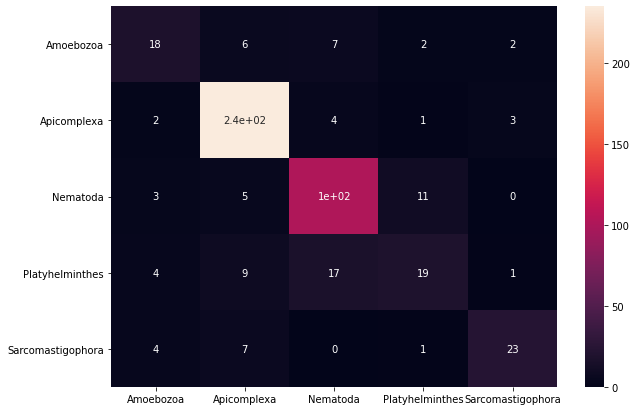

In [70]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
confusion = confusion_matrix(label,preds)
df_cm = pd.DataFrame(confusion, index = le.classes_,
                  columns = le.classes_)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

In [ ]:
!unzip /content/ResNet200D.zip

### GradCam

In [ ]:
%cd /content/A-journey-into-Convolutional-Neural-Network-visualization-

In [71]:
# from utils import *
# from visualisation.core.utils import device 
# from visualisation.core.utils import image_net_postprocessing
# from torchvision.transforms import ToTensor, Resize, Compose, ToPILImage
# from visualisation.core import *
# from visualisation.core.utils import image_net_preprocessing

# test_transform = transforms.Compose([transforms.Resize((224,224)),
#                                      transforms.ToTensor(),
#                                      image_net_preprocessing])

vis = GradCam(model, device)

In [72]:
def plot_get(img_path):
  img = test_transform(Image.open(img_path).convert('RGB')).unsqueeze(0).to(device)
  arr = tensor2img(vis(img, None,postprocessing=image_net_postprocessing)[0])
  arr = (arr*255).astype(np.uint8)
  img_path = img_path.split('/')
  save_path = '/'.join(img_path[:6]) + '/' + img_path[4] + '=' + img_path[6]
  Image.fromarray(arr).save(save_path)
  return Image.fromarray(arr)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


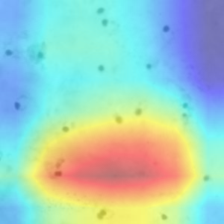

In [73]:
plot_get("/content/EffNet-B0/Phylum/Apicomplexa/Pf_rings_thick/Pf_rings_thickC_3_214.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


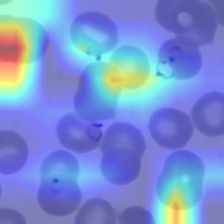

In [74]:
plot_get("/content/EffNet-B0/Phylum/Apicomplexa/Pf_rings_thin/Pf_rings_thinE_0_213.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


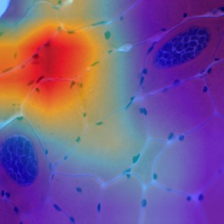

In [75]:
plot_get("/content/EffNet-B0/Phylum/Apicomplexa/Sarcocystis/Sarcocystis_muscle_HE_MI_2_rotated_0_345.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


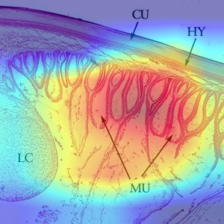

In [76]:
plot_get("/content/EffNet-B0/Phylum/Nematoda/Ascaris cuticle/Ascaris_cuticle_cross_section_0_40.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


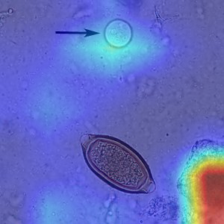

In [77]:
plot_get("/content/EffNet-B0/Phylum/Nematoda/Trichuris and Ecoli/Trichuris_and_Ecoli_HB_0_371.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


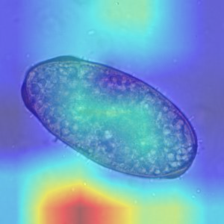

In [78]:
plot_get("/content/EffNet-B0/Phylum/Nematoda/lumbricoides/A_lumbricoides_infert_Leiden_B_0_22.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


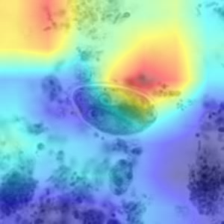

In [79]:
plot_get("/content/EffNet-B0/Phylum/Sarcomastigophora/Giardia cyst/Giardia_cyst_tric2_3_169.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


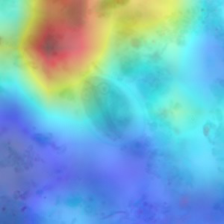

In [80]:
plot_get("/content/EffNet-B0/Phylum/Sarcomastigophora/Giardia cyst-2/Giardia_cyst_tric10_0_171.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


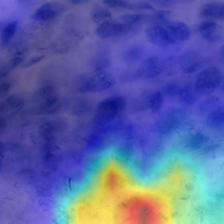

In [81]:
plot_get("/content/EffNet-B0/Phylum/Sarcomastigophora/Giardia troph/Giardia_troph_VT_0_181.jpg")

In [82]:
!zip -q EffNet-B0.zip EffNet-B0

# Species

In [83]:

le = LabelEncoder()

train['species_label'] = le.fit_transform(train['species'])
val['species_label'] = le.transform(val['species'])

In [84]:

class_counts = train['species_label'].value_counts().to_dict()
train_weights = torch.tensor([1/class_counts[label] for label in train['species_label'].values])

train_dataset = SpeciesDataset(train, train_transformer,'species')

class_counts = val['species_label'].value_counts().to_dict()
val_weights = torch.tensor([1/class_counts[label] for label in val['species_label'].values])

val_dataset = SpeciesDataset(val, val_transformer,'species')

In [ ]:
len(le.classes_)

16

In [85]:
torch.cuda.empty_cache()

In [86]:
model = EB0(
    num_classes_classifier=16,
    train_weights=train_weights,
    val_weights=val_weights,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    sampling_rate = [2160,720]
    )

In [87]:
early_stop_callback = EarlyStopping(
   monitor='val_accuracy',
   min_delta=0.00,
   patience=20,
   verbose=False,
   mode='max'
)

model_ckpt = ModelCheckpoint(
    monitor='val_accuracy',
    dirpath='./',
    filename='Effnet-{val_loss:.2f}-{val_accuracy:.2f}',
    mode='max')

trainer = pl.Trainer(gpus=1,max_epochs=120,accumulate_grad_batches=4,num_sanity_val_steps=2,callbacks=[early_stop_callback,model_ckpt])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params
-----------------------------------------------------
0 | loss_fn         | CrossEntropyLoss | 0     
1 | img_transformer | EfficientNet     | 4.0 M 
-----------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.112    Total estimated model params size (MB)


1

### Accuracy

In [89]:
from sklearn.metrics import classification_report, confusion_matrix

val_dataset = SpeciesDataset(val, val_transformer,'species')
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=51)

model = ResNet200d.load_from_checkpoint("/content/Effnet-val_loss=1.41-val_accuracy=0.64.ckpt",
                                        num_classes_classifier=16,
                                        train_weights=None,
                                        val_weights=None,
                                        train_dataset=None,
                                        val_dataset=None,
                                        sampling_rate = [0,0]
                                        )
model.cuda()
model.eval()
preds = np.array([])
label = np.array([])
with torch.no_grad():
  for batch in val_loader:
    images = batch["images"].cuda()
    labels = batch['labels']
    label = np.append(label,labels)
    prediction = model(images)
    preds = np.append(preds,prediction.argmax(dim=1).view(labels.size()).cpu().numpy())


print(classification_report(label,preds,target_names=le.classes_))

                           precision    recall  f1-score   support

         Ancyclostoma sp.       0.50      0.70      0.58        20
     Ascaris lumbricoides       0.71      0.63      0.67        35
      Cryptosporidium sp.       0.64      0.45      0.53        20
  Cyclospora cayetanensis       0.64      0.70      0.67        40
  Dibothriocephalus latus       0.40      0.48      0.44        25
    Entamoeba histolytica       0.76      0.89      0.82        35
  Enterobius vermicularis       0.40      0.40      0.40        20
       Giardia duodenalis       0.69      0.71      0.70        35
          Hymenolepis spp       0.67      0.40      0.50        25
    Plasmodium falciparum       0.65      0.73      0.69        45
      Plasmodium malariae       0.80      0.40      0.53        40
         Plasmodium ovale       0.49      0.51      0.50        35
         Plasmodium vivax       0.56      0.69      0.62        45
          Sarcocystis sp.       0.64      0.70      0.67     

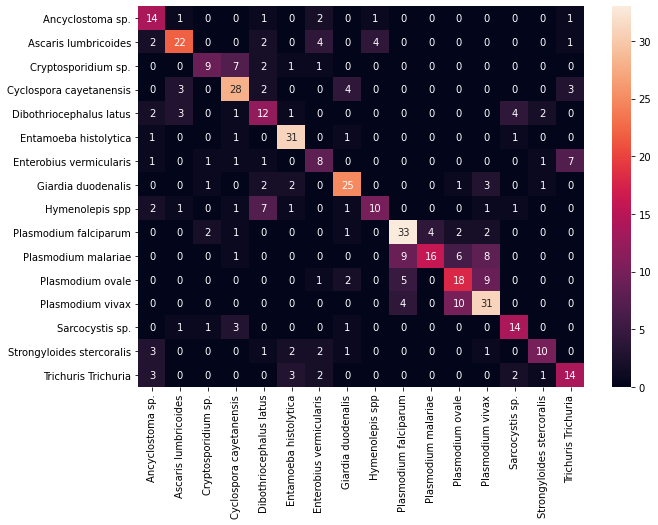

In [90]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
confusion = confusion_matrix(label,preds)
df_cm = pd.DataFrame(confusion, index = le.classes_,
                  columns = le.classes_)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

### GradCam

In [ ]:
%cd /content/A-journey-into-Convolutional-Neural-Network-visualization-

In [91]:
# from utils import *
# from visualisation.core.utils import device 
# from visualisation.core.utils import image_net_postprocessing
# from torchvision.transforms import ToTensor, Resize, Compose, ToPILImage
# from visualisation.core import *
# from visualisation.core.utils import image_net_preprocessing

# test_transform = transforms.Compose([transforms.Resize((224,224)),
#                                      transforms.ToTensor(),
#                                      image_net_preprocessing])

vis = GradCam(model, device)

In [92]:
def plot_get(img_path):
  img = test_transform(Image.open(img_path).convert('RGB')).unsqueeze(0).to(device)
  arr = tensor2img(vis(img, None,postprocessing=image_net_postprocessing)[0])
  arr = (arr*255).astype(np.uint8)
  img_path = img_path.split('/')
  save_path = '/'.join(img_path[:6]) + '/' + img_path[4] + '=' + img_path[6]
  Image.fromarray(arr).save(save_path)
  return Image.fromarray(arr)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


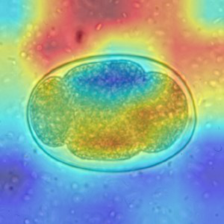

In [93]:
plot_get("/content/EffNet-B0/Species/Ancyclostoma/Hookworm/Hookworm_2x2_B_0_3.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


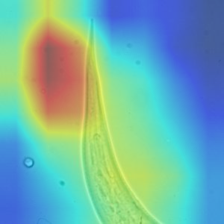

In [94]:
plot_get("/content/EffNet-B0/Species/Ancyclostoma/Hookworm_filariform/Hookworm_filariform_posterior_A_0_11.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


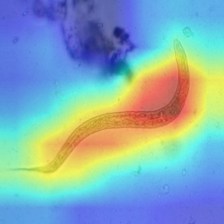

In [95]:
plot_get("/content/EffNet-B0/Species/Ancyclostoma/Hookworm_rhabditiform/Hookworm_rhabditiform_2_0_7.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


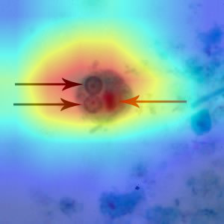

In [96]:
plot_get("/content/EffNet-B0/Species/Entamoeba/Ehistdisp cyst/Ehistdisp_cyst_tric3_0_120.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


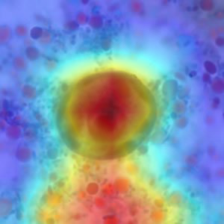

In [97]:
plot_get("/content/EffNet-B0/Species/Entamoeba/Ehistdisp cyst tric/Ehistdisp_cyst_tric6_KS_0_123.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


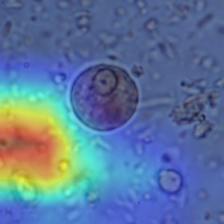

In [98]:
plot_get("/content/EffNet-B0/Species/Entamoeba/Ehistdisp cyst wtmt/Ehistdisp_cyst_wtmt_0_115.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


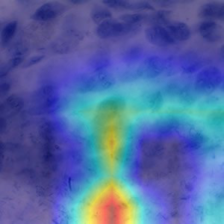

In [99]:
plot_get("/content/EffNet-B0/Species/Giardia duodenalis/Giardia troph/Giardia_troph_VT_0_181.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


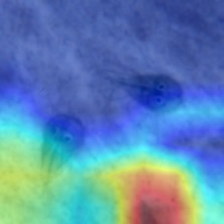

In [100]:
plot_get("/content/EffNet-B0/Species/Giardia duodenalis/Giardia troph kohn/Giardia_troph_kohn_0_182.jpg")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


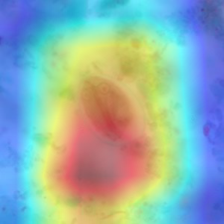

In [101]:
plot_get("/content/EffNet-B0/Species/Giardia duodenalis/Giardia_cyst_tric/Giardia_cyst_tric10_0_171.jpg")

In [102]:
!zip -q EffNet-B0.zip EffNet-B0